In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import patsy

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/Theano-0.10.0.dev1-py3.6.egg/theano/gpuarray/__init__.py", line 179, in <module>
    use(config.device)
  File "/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/Theano-0.10.0.dev1-py3.6.egg/theano/gpuarray/__init__.py", line 166, in use
    init_dev(device, preallocate=preallocate)
  File "/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/Theano-0.10.0.dev1-py3.6.egg/theano/gpuarray/__init__.py", line 65, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9419)
  File "pygpu/gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9110)
  File "pygpu/gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13472)
pygpu.gpuarray.GpuArrayException: Unknown device error:

# Data

It's time for yet another Insight Data Challenge! 

This is another "conversion rate" data challenge. We are provided data on some users, and want to predict whether they will "convert" based on that data.

Here's the schema:

- `country`: inferred based on IP address. A string.
- `age`: an integer number
- `new_user`: binary 1/0 outcome.
- `source`: where they came from. 3 categories.
    - `ads`: came via ads
    - `seo`: came via search engine
    - `direct`: came directly to site
- `total_pages_visited`: integer. a measure of engagement
- `converted`: the variable to predict. Binary.

# Initial Thoughts

- We are looking at a Bernoulli distribution as the likelihood function for the `converted` variable.
- Use `patsy` to encode the categorical data.
- Do logistic regression on the variables to see which ones are most predictive of conversion.

# Exploratory Data Analysis

We first begin by loading the data.

In [2]:
df = pd.read_csv('data/conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Check Column Values 

### Country

I want to make sure that the "country" column is clean. 

In [3]:
df.groupby('country').count()

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,76602,76602,76602,76602,76602
Germany,13056,13056,13056,13056,13056
UK,48450,48450,48450,48450,48450
US,178092,178092,178092,178092,178092


Not bad, large numbers for each (10<sup>4</sup> to 10<sup>5</sup>). A bit of imbalance. No outlier data points.

### Age
Let's now check the "age" column.

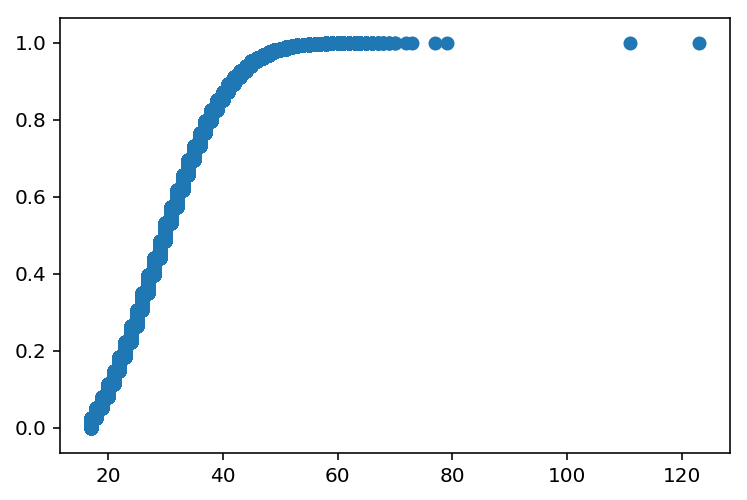

In [4]:
def ecdf_scatter(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

x, y = ecdf_scatter(df['age'])
plt.scatter(x, y)
plt.show()

In [5]:
p95, p99 = np.percentile(df['age'], [95, 99])
p95, p99

(45.0, 52.0)

There clearly are some outliers in the data. We have users that are older than 100 years of age. The oldest person in the world is 117 years. That person lives in none of the {{ len(set(df['country'])) }} countries in the dataset.

In addition, the 95th and 99th percentile of the dataset are {{ p95 }} years and {{ p99 }} years respectively. I think it is safe to exclude all datapoints with users older than {{ p99 }} years. Anything below the age of {{ p99 }} years old is very likely to be in the target market of an internet company.

### New User

Now, I would like to check about the `new_user` column.

In [6]:
df.groupby('new_user').count()

,country,age,source,total_pages_visited,converted
new_user,,,,,
0,99456,99456,99456,99456,99456
1,216744,216744,216744,216744,216744


No outliers. Also a bit imbalanced, but not too exaggerated in imbalance.

### Source

Let's now look at the `source` column.

In [7]:
df.groupby('source').count()

,country,age,new_user,total_pages_visited,converted
source,,,,,
Ads,88740,88740,88740,88740,88740
Direct,72420,72420,72420,72420,72420
Seo,155040,155040,155040,155040,155040


### Total Pages Visited

Let's now look at the `total_pages_visited` column.

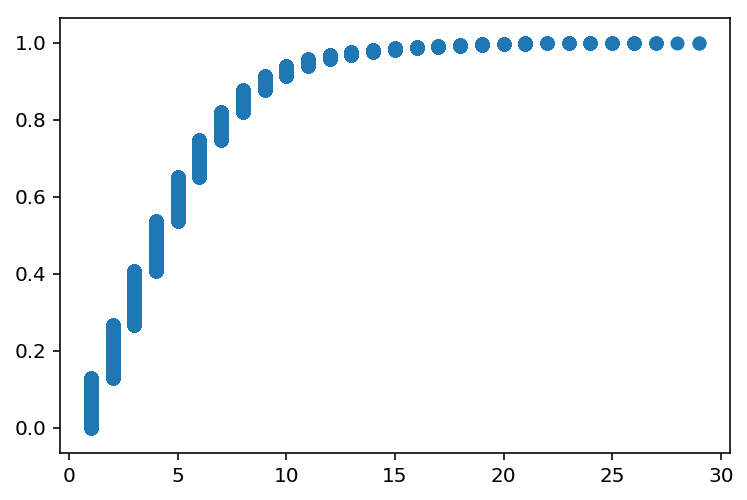

In [8]:
x, y = ecdf_scatter(df['total_pages_visited'])
plt.scatter(x, y)

This is clearly an integer column, but I wouldn't consider it to be ordinal by any measure. 

### Converted

Now, let's look at the "converted" column. This is the column we're trying to predict.

In [9]:
df.groupby('converted').count()

,country,age,new_user,source,total_pages_visited
converted,,,,,
0,306000,306000,306000,306000,306000
1,10200,10200,10200,10200,10200


Ok, quite imbalanced. Keep this in the back pocket. About 1:30 ratio.

Good thing there are no "bad" values in there.

## Missing Values

I will use a package called `missingno` to check that the data are all present. 

In [10]:
import missingno as msno

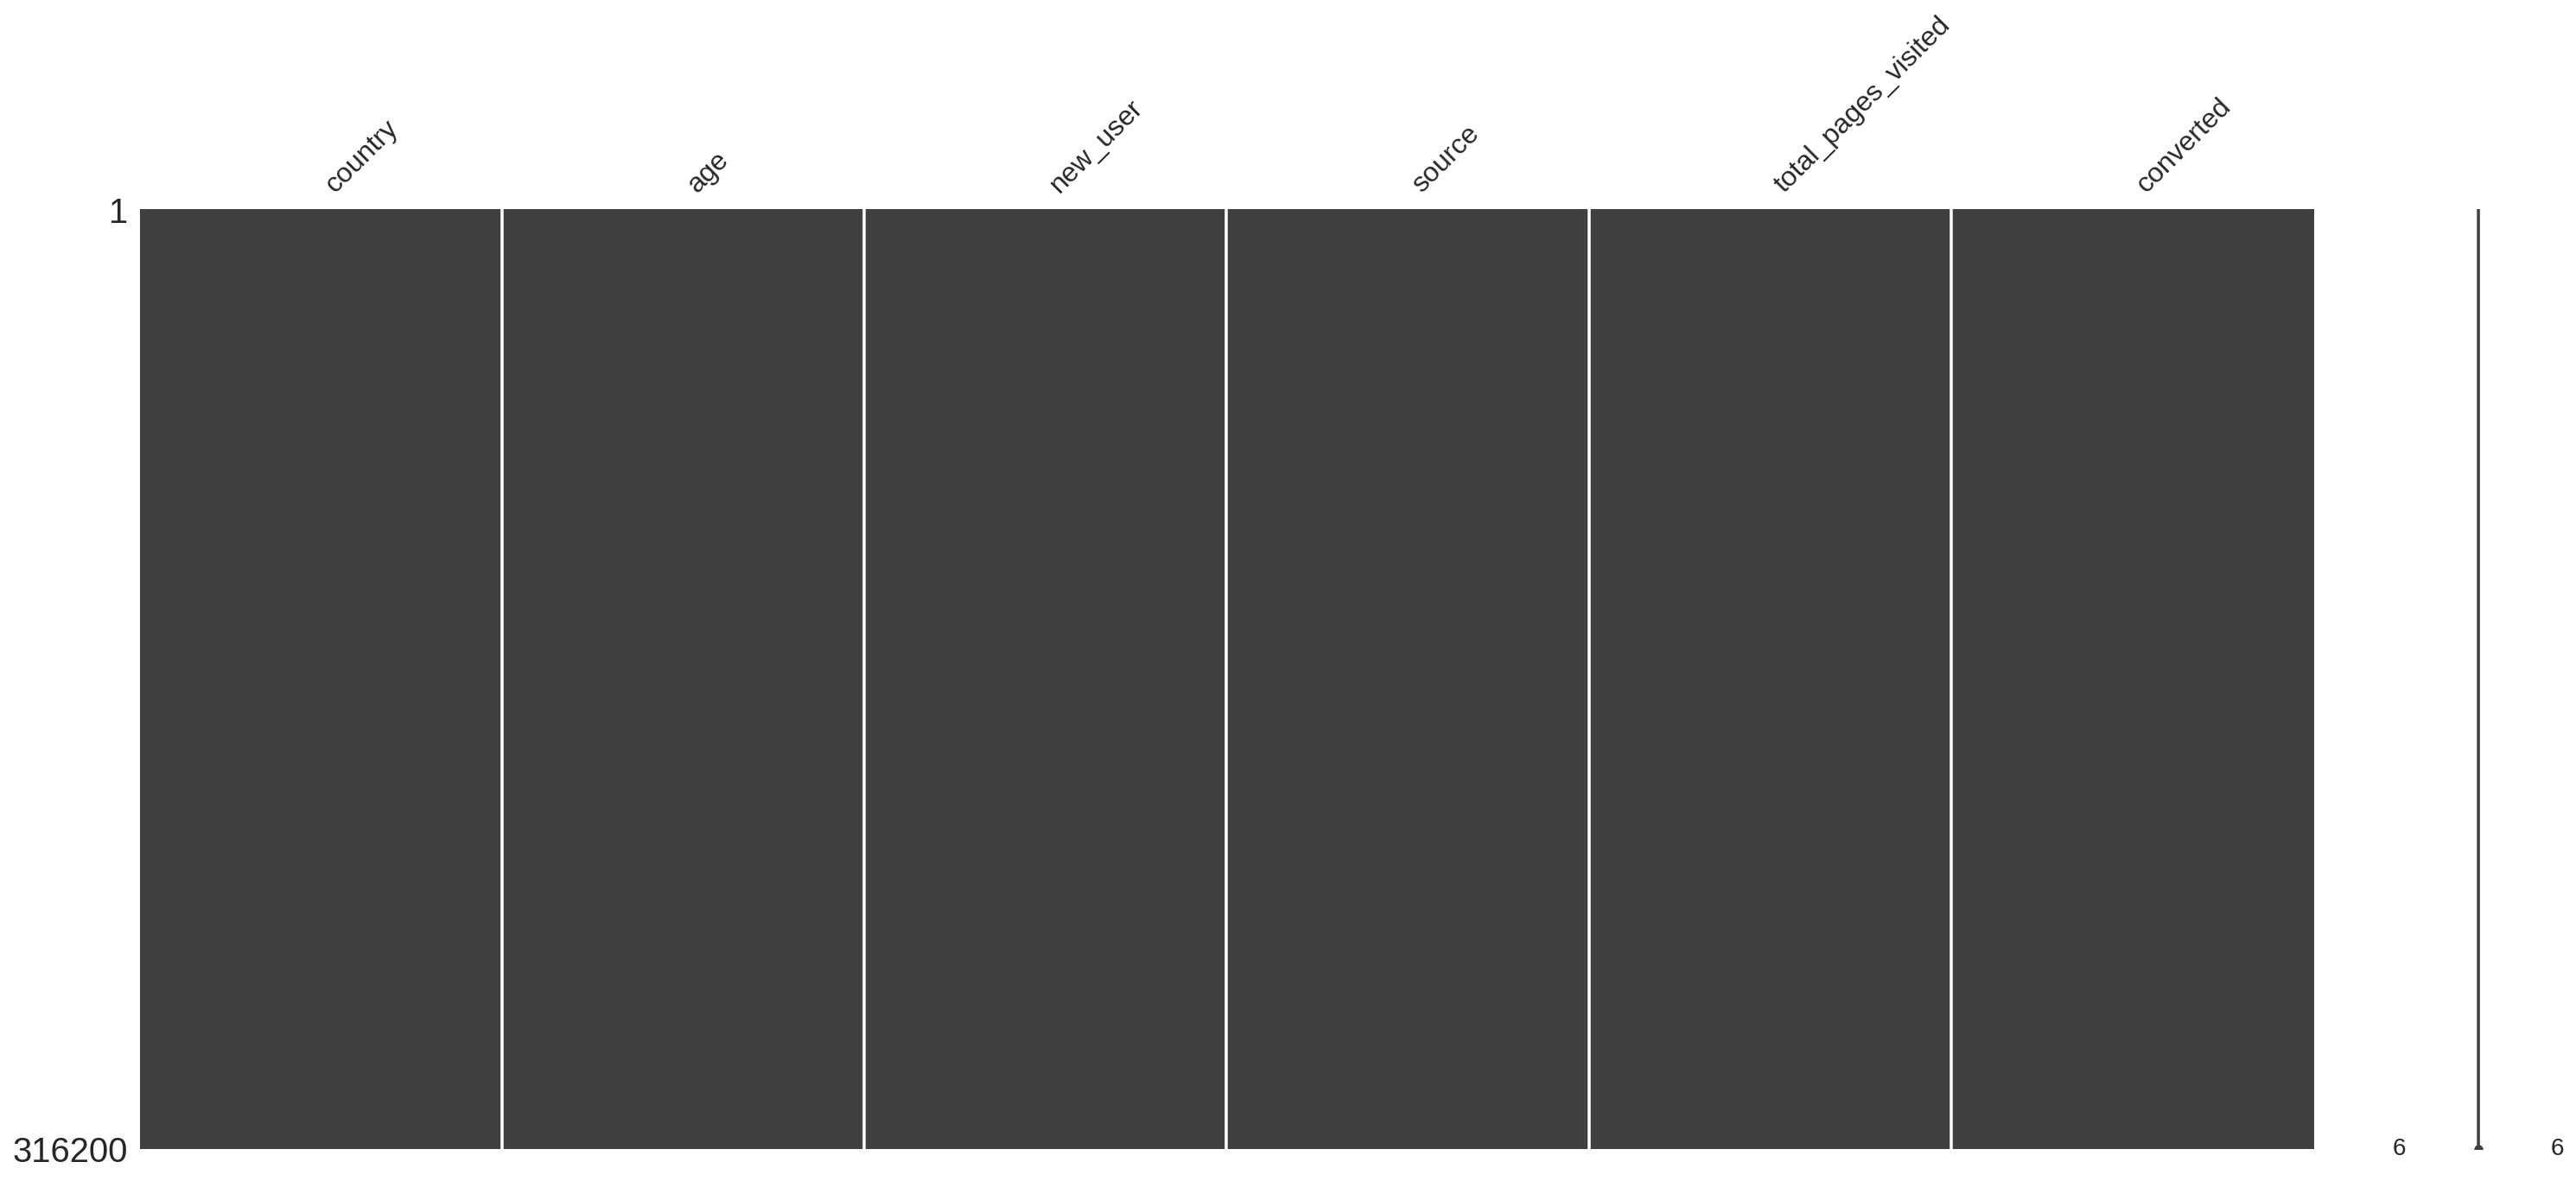

In [11]:
msno.matrix(df)

This is good! The data are complete and filled everywhere. No holes. Awesome stuff.

# Data Cleaning

Based on the above, there's only one way that I can see is necessary for cleaning: we will remove any data where the age is greater than {{ p99 }}.

In [12]:
cond = df['age'] <= 52
df_cleaned = df[cond]
df_cleaned.shape

(313503, 6)

The class imbalance is now as follows:

In [13]:
df_cleaned.groupby('converted').count()

,country,age,new_user,source,total_pages_visited
converted,,,,,
0,303316,303316,303316,303316,303316
1,10187,10187,10187,10187,10187


This is good, we still have a roughly 30:1 distribution of data.

With 10,000+ data points in the minority class, I will sample {{ df_cleaned.groupby('converted').count()['total_pages_visited'][1] }} points from class 0.

In [14]:
n_subsample = df_cleaned.groupby('converted').count()['total_pages_visited'][1]
not_converted = (df_cleaned['converted'] == 0)
converted = (df_cleaned['converted'] == 1)

df_not_converted = df_cleaned[not_converted].sample(n_subsample)
df_converted = df_cleaned[converted]

df_sub = pd.concat([df_converted, df_not_converted])

Now, the dataset looks much more balanced:

In [15]:
df_sub.groupby('converted').count()

,country,age,new_user,source,total_pages_visited
converted,,,,,
0,10187,10187,10187,10187,10187
1,10187,10187,10187,10187,10187


Next up, we need to use `patsy` to do the dmatrix conversion.

In [16]:
df_train = patsy.dmatrix('country + age + new_user + source + total_pages_visited -1', df_sub, return_type="dataframe")
df_train = df_train.astype('float32')
df_train.head()

,country[China],country[Germany],country[UK],country[US],source[T.Direct],source[T.Seo],age,new_user,total_pages_visited
54,0.0,0.0,0.0,1.0,1.0,0.0,25.0,1.0,18.0
72,0.0,0.0,0.0,1.0,0.0,1.0,33.0,0.0,15.0
87,0.0,0.0,0.0,1.0,1.0,0.0,18.0,0.0,19.0
130,0.0,0.0,0.0,1.0,0.0,0.0,17.0,0.0,19.0
182,0.0,0.0,0.0,1.0,0.0,0.0,19.0,0.0,9.0


# Model Construction

We will do a Bayesian logistic regression. The logistic function is:

$$ \frac{1}{1 + e^{-(\beta_{0} + \beta_{1} + \beta_{2} + ... + \beta_{k})}} $$

Where $ \beta_{0} $ is the intercept, and $ \beta_{1...k} $ are the weight parameters for the logistic regression function.

We will put the following priors on the weights:

- $ \beta_{0...k} \sim N(0, 100^2) $

In [17]:
df_train.head()

,country[China],country[Germany],country[UK],country[US],source[T.Direct],source[T.Seo],age,new_user,total_pages_visited
54,0.0,0.0,0.0,1.0,1.0,0.0,25.0,1.0,18.0
72,0.0,0.0,0.0,1.0,0.0,1.0,33.0,0.0,15.0
87,0.0,0.0,0.0,1.0,1.0,0.0,18.0,0.0,19.0
130,0.0,0.0,0.0,1.0,0.0,0.0,17.0,0.0,19.0
182,0.0,0.0,0.0,1.0,0.0,0.0,19.0,0.0,9.0


In [18]:
df_sub['converted'].dtypes

dtype('int64')

In [19]:
import theano.tensor as tt
import theano

# X_input = theano.shared(X_train)
# Y_input = theano.shared(Y_train)

def invlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

with pm.Model() as model:
    # int_mu = pm.Normal('int_mu', 0, 100**2)
    # int_sd = pm.HalfCauchy('int_sd', 100**2)
    # intercept = pm.Normal('intercept', int_mu, int_sd)
    intercept = pm.Normal('intercept', 0, 100**2)
    weights = pm.Normal('weights', 0, 100**2, shape=(df_train.shape[1],))
    
    X = tt.dot(weights, df_train.T) + intercept
    
    logreg = invlogit(X)
    
    out = pm.Bernoulli('likelihood', p=logreg, observed=df_sub['converted'])

In [20]:
with model:
    # trace = pm.sample(2000)
    trace = pm.sample(100000, step=pm.Metropolis())

100%|██████████| 100500/100500 [13:36<00:00, 132.03it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb2832ccf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feadf4e0da0>]], dtype=object)

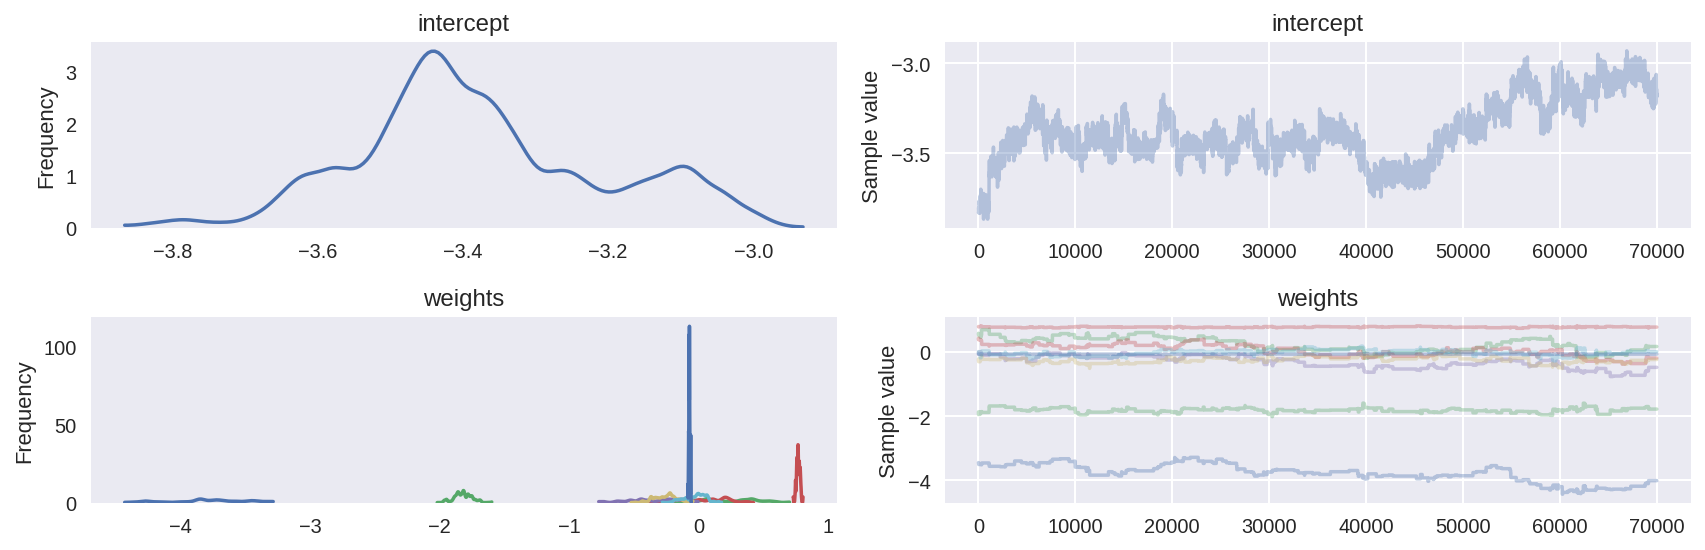

In [21]:
pm.traceplot(trace[30000:])

# Results

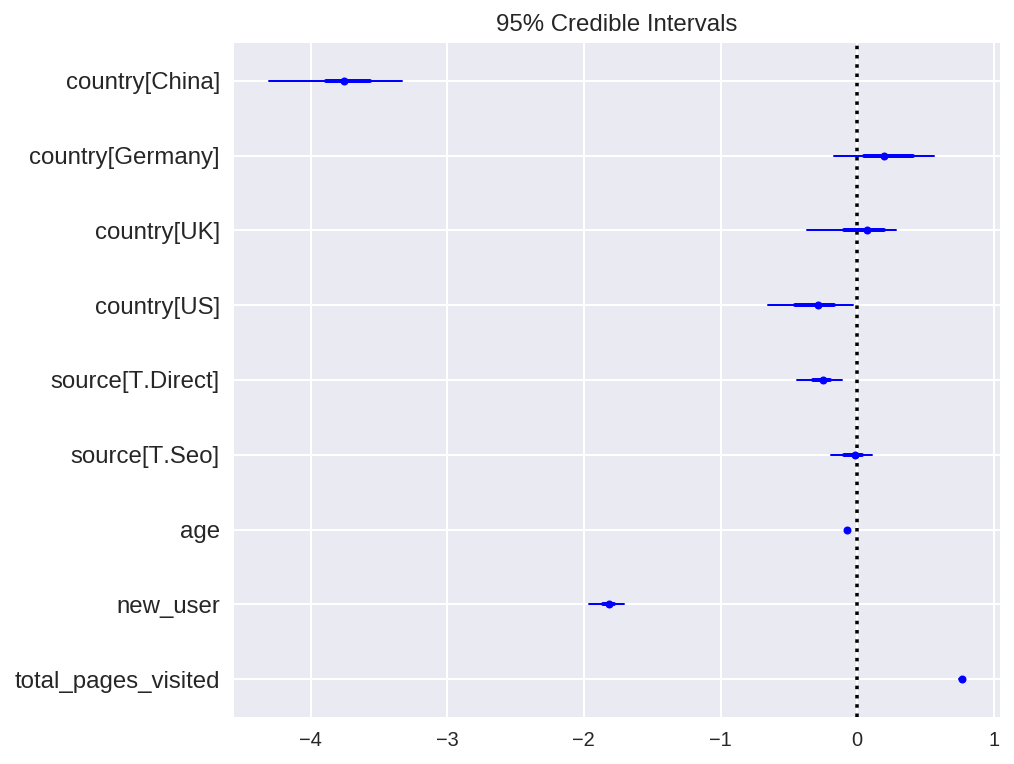

In [22]:
pm.forestplot(trace[30000:], varnames=['weights'], ylabels=df_train.columns)

Number of pages visited is probably a measure of engagement on the website. Having more compelling content will probably increase conversion rate more than anything else.

Users based in China are least likely to be buying the software product. New users are also less likely to buy the product.

# Model Evaluation

I will use posterior predictive checks to draw 50,000 samples from the posterior distribution, and plot the ROC curve of the predictions. 

In [23]:
with model:
    data = pm.sample_ppc(trace, samples=50000)

100%|██████████| 50000/50000 [01:47<00:00, 463.90it/s]


In [24]:
data['likelihood'].T.shape[0]

20374

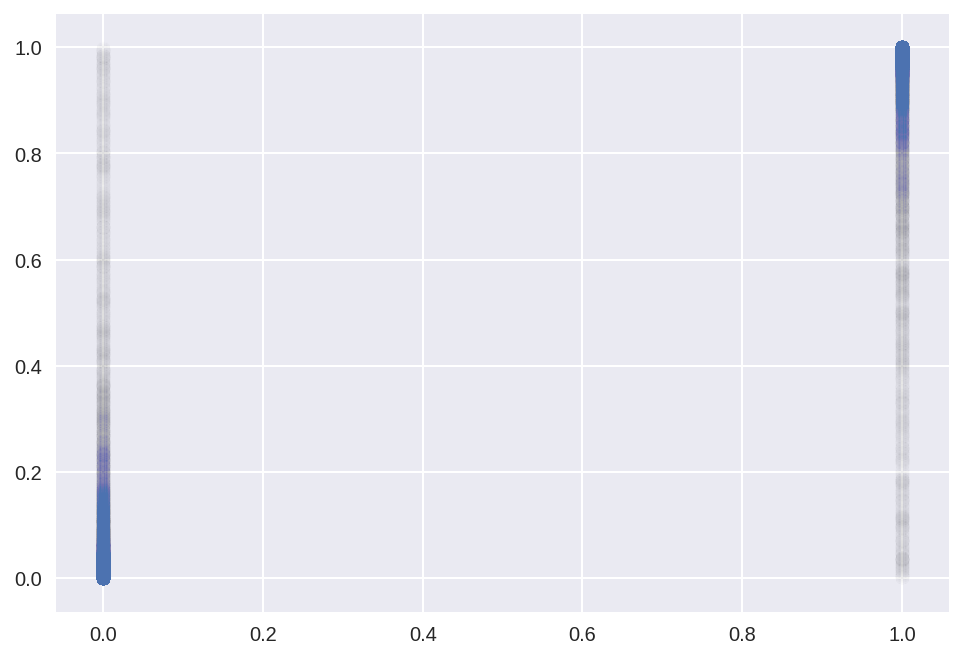

In [25]:
preds = data['likelihood'].T.mean(axis=1)
plt.scatter(df_sub['converted'], preds, alpha=0.005)

I think the predictive accuracy is good. Let me check the ROC curve.

In [26]:
preds_roc = np.round(preds)
from sklearn.metrics import roc_auc_score


roc_auc_score(preds_roc, df_sub['converted'])

0.94179291343313576

Let's use `scikit-plot` to visualize the ROC curve.

In [27]:
import scikitplot.plotters as skplt

In [32]:
preds.shape, df_sub['converted'].shape

((20374,), (20374,))

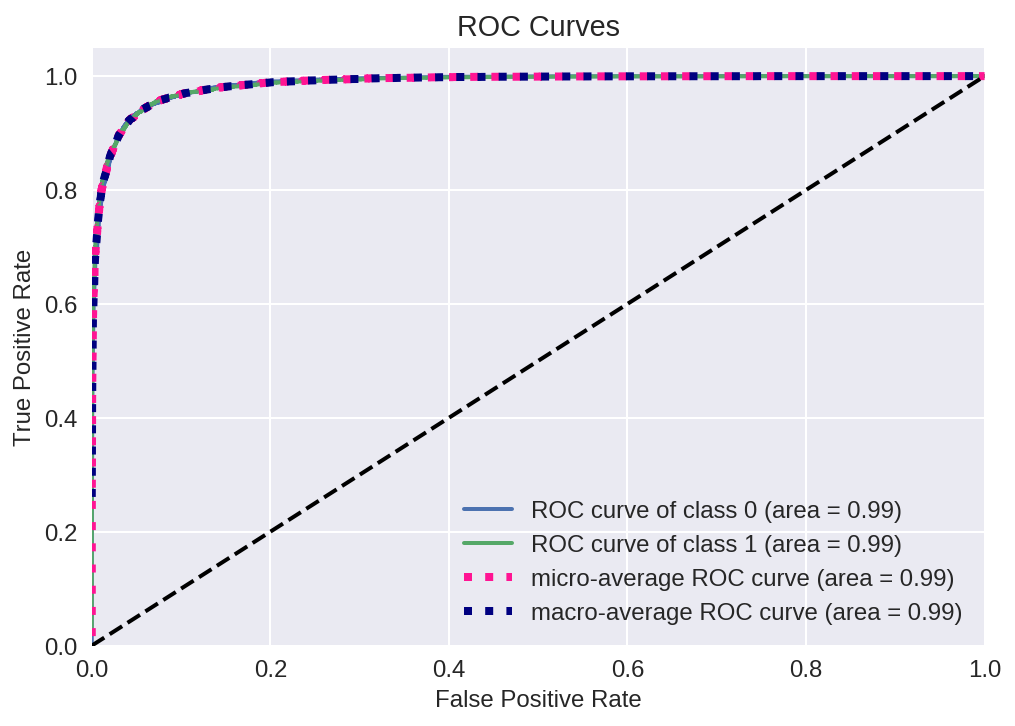

In [42]:
preds_proba = np.zeros(shape=(preds.shape[0], 2))
preds_proba[:, 0] = 1 - preds
preds_proba[:, 1] = preds
skplt.plot_roc_curve(df_sub['converted'].values, preds_proba)

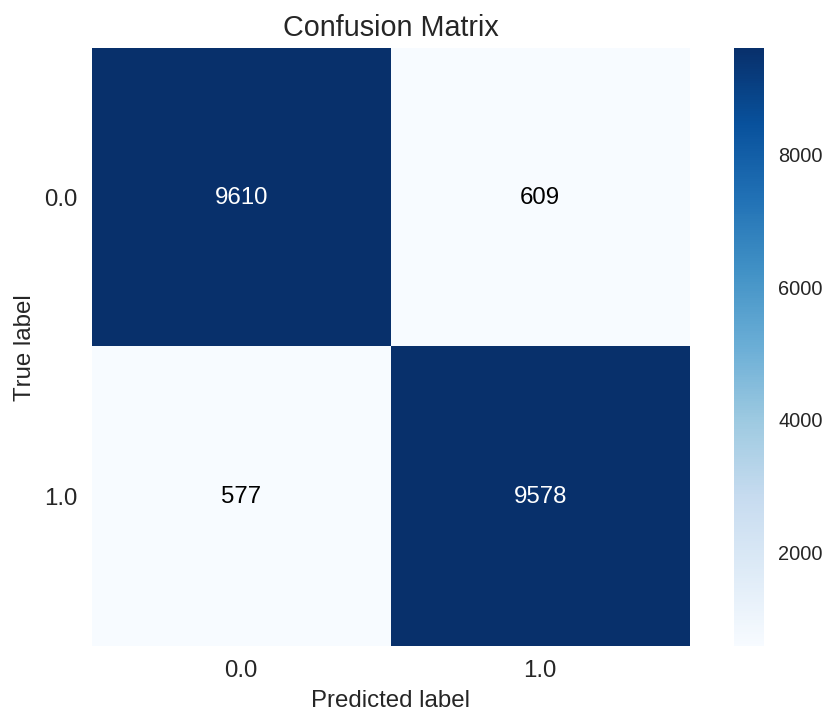

In [37]:
skplt.plot_confusion_matrix(preds_roc.reshape(-1), df_sub['converted'].values.reshape(-1))

One thing I learned from Twitter recently was that with Bayes, we don't need to do CV. Here's the thread from which I learned this. 

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr"><a href="https://twitter.com/fonnesbeck">@fonnesbeck</a> Saw the PPC section of your PyCon 2017 stats tutorial - is there literature on why cross-val not necessary in Bayes?</p>&mdash; Eric Ma (@ericmjl) <a href="https://twitter.com/ericmjl/status/886584316624592898">July 16, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">There aren&#39;t any parameters to tune, which is usually why you are cross-validating. You can do leave-one-out in PyMC3 for model selection.</p>&mdash; Chris Fonnesbeck (@fonnesbeck) <a href="https://twitter.com/fonnesbeck/status/886586957920391168">July 16, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">I&#39;ve seen crossval to build a distribution insample and use as prior out of sample. Can&#39;t find reference right now but seems clever to me.</p>&mdash; Greg Stoddard (@gregstod) <a href="https://twitter.com/gregstod/status/886609784253947905">July 16, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

It makes fuzzy sense to me right now. Putting it in my own words... 

PPC is a matter of "model fit", not a matter of "model selection" (though right now, they seem to me to be related). If the model is fitting the data well, then the PPC samples will look like the original data samples. Cross-validation is only needed in the case where we have to check parameters that need to be tuned. 

Also, doing CV is a computationally expensive thing for inference.

# Conclusions

1. The company should increase website engagement. That will bring in the biggest ROI.
1. To increase their market share, the company may want to consider increasing engagement of users in China and engagement of new users.